In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_excel("dataset/amazon_reviews_us_Electronics_v1_00.xlsx", nrows=999999)
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5.0,0.0,0.0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5.0,0.0,0.0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5.0,1.0,1.0,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1.0,0.0,0.0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5.0,1.0,1.0,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [4]:
df = df[['customer_id', 'product_id', 'star_rating', 'product_title']]
df.head()

,customer_id,product_id,star_rating,product_title
0,41409413,B00428R89M,5.0,yoomall 5M Antenna WIFI RP-SMA Female to Male ...
1,49668221,B000068O48,5.0,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor"
2,12338275,B000GGKOG8,5.0,Channel Master Titan 2 Antenna Preamplifier
3,38487968,B000NU4OTA,1.0,LIMTECH Wall charger + USB Hotsync & Charging ...
4,23732619,B00JOQIO6S,5.0,Skullcandy Air Raid Portable Bluetooth Speaker


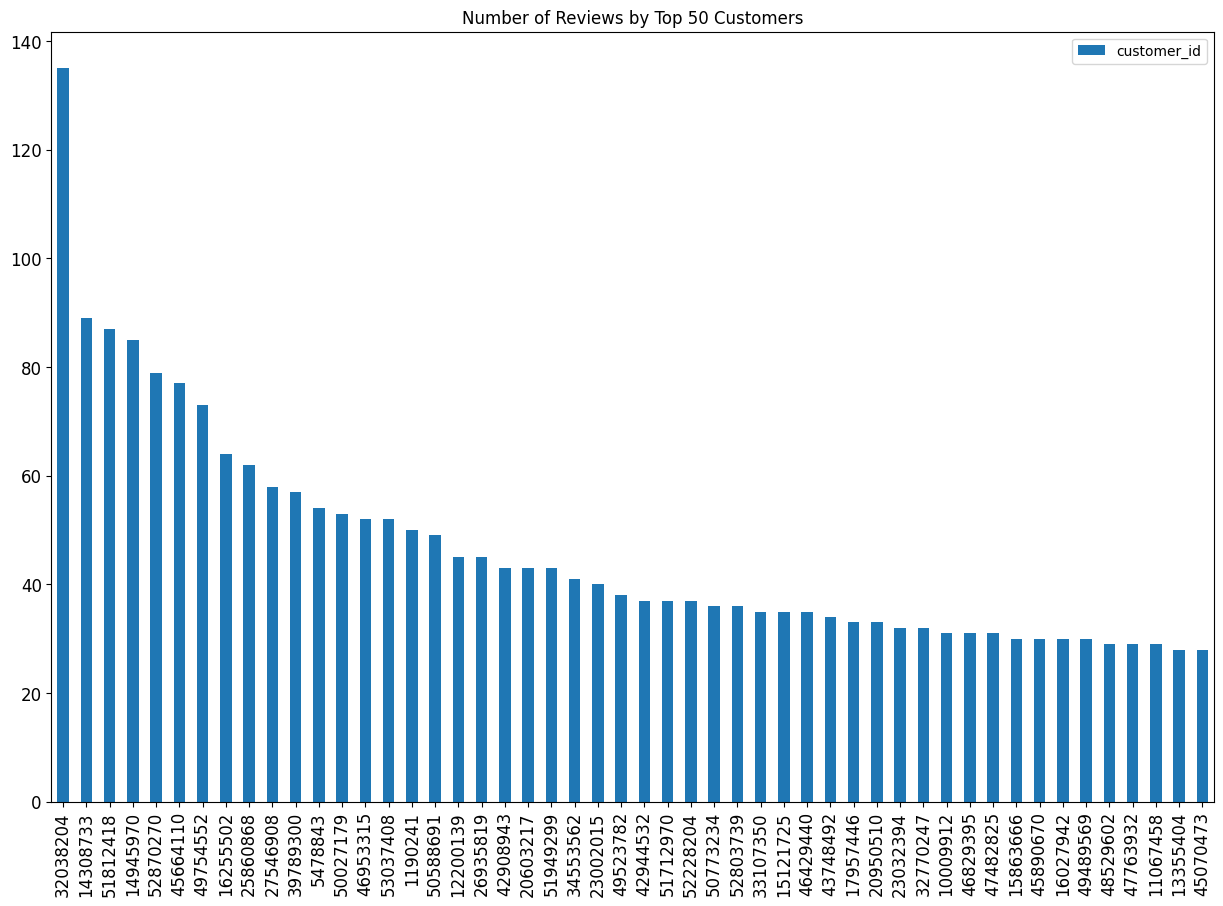

In [5]:
df['customer_id'].value_counts()[0:50].plot(kind='bar', title='Number of Reviews by Top 50 Customers', figsize=(15, 10),
                                            legend=True, fontsize=12)
plt.show()

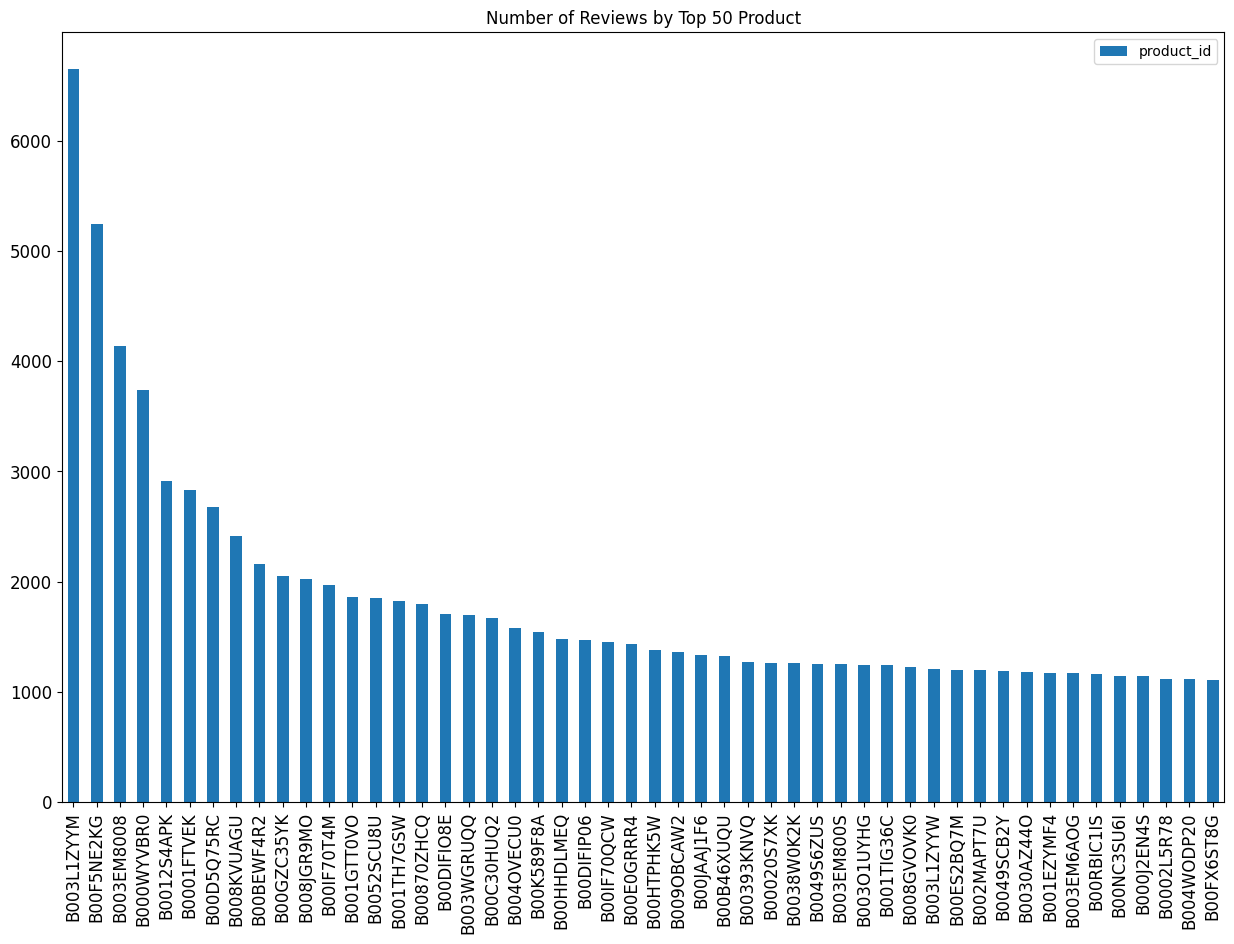

In [11]:
df['product_id'].value_counts()[0:50].plot(kind='bar', title='Number of Reviews by Top 50 Product', figsize=(15, 10),
                                           legend=True, fontsize=12)
plt.show()

In [12]:
df2 = df.groupby(['product_id'])
list_product_rating = []
for product, y in df2:
    list_product_rating.append(
        {'product_id': product, 'average_rating': y['star_rating'].mean(), 'review_count': y.shape[0]})

/tmp/ipykernel_34769/2273322353.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for product,y in df2:


In [14]:
df_avg_rating = pd.DataFrame(list_product_rating)
df_avg_rating_sorted = df_avg_rating.sort_values(by='review_count', ascending=False)

<AxesSubplot: title={'center': 'Average Rating for Top 50 Products'}, xlabel='product_id'>

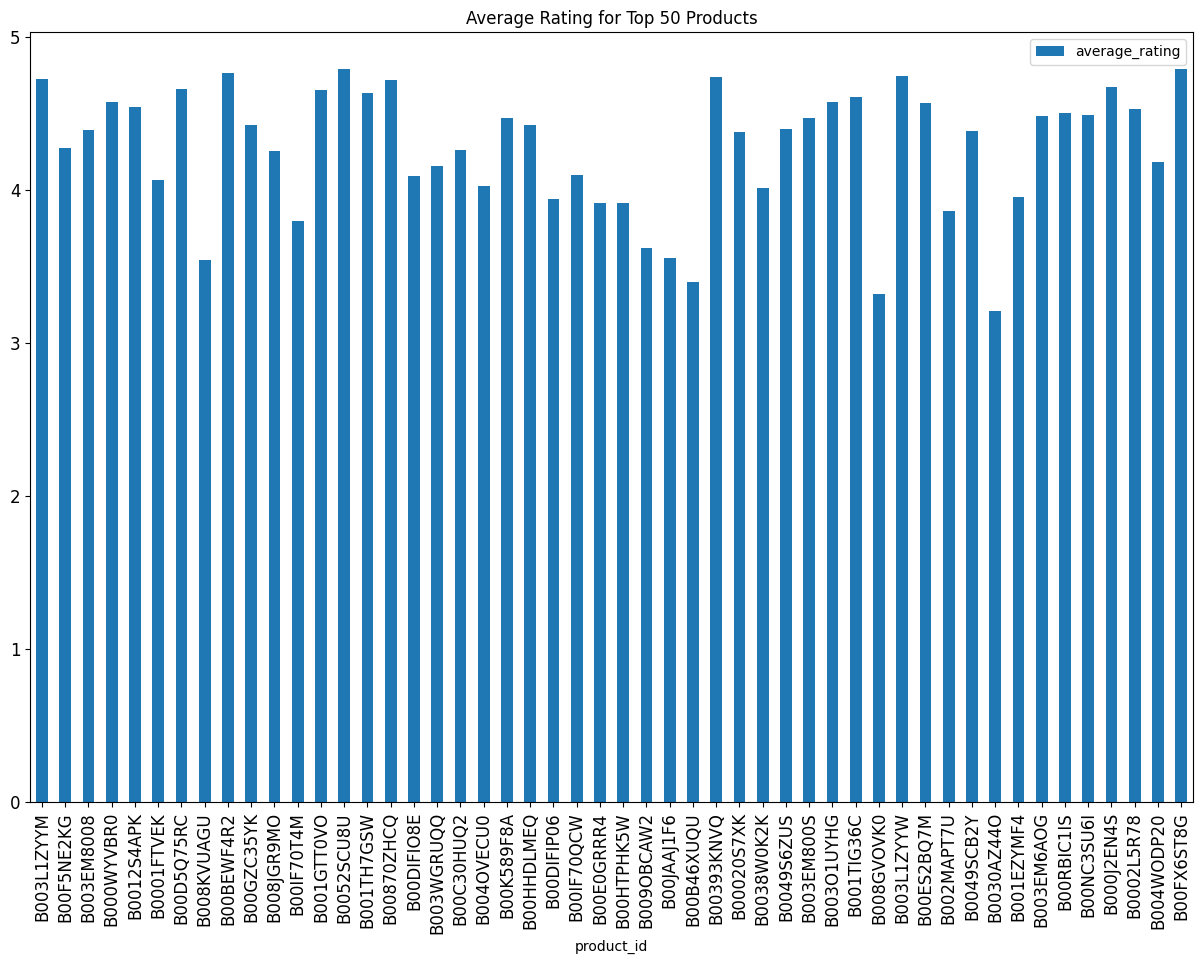

In [15]:
df_avg_rating_sorted[['product_id', 'average_rating']][:50].plot(kind='bar', x='product_id',
                                                                 title='Average Rating for Top 50 Products',
                                                                 figsize=(15, 10), legend=True, fontsize=12)

<AxesSubplot: title={'center': 'Rating Distribution'}, ylabel='star_rating'>

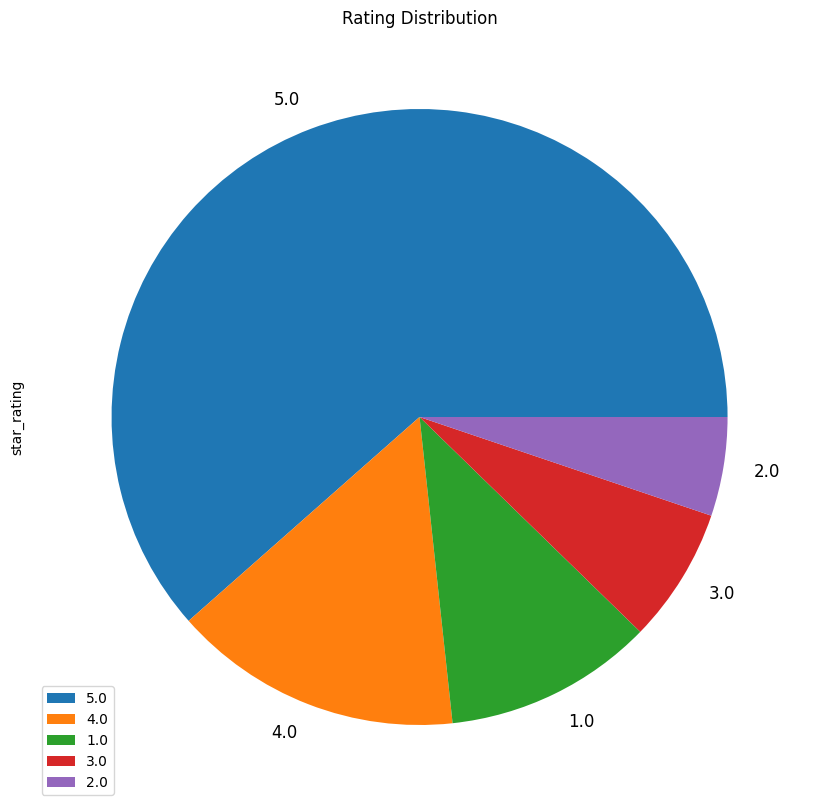

In [16]:
df['star_rating'].value_counts().plot(kind='pie', title='Rating Distribution', figsize=(15, 10), legend=True,
                                      fontsize=12)


In [3]:
import pandas as pd
df = pd.read_excel("dataset/amazon_reviews_us_Electronics_v1_00.xlsx", nrows=999999)
df = df[['customer_id', 'product_id', 'star_rating']]
# Filter long tail
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

In [5]:
customers = customers[customers >= 5]
products = products[products >= 6]

In [6]:
reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(
    pd.DataFrame({'product_id': products.index}))
reduced_df

,customer_id,product_id,star_rating
0,49668221,B000068O48,5.0
1,48577367,B000068O48,3.0
2,28572924,B000068O48,1.0
3,52478909,B000068O48,5.0
4,3286823,B000068O48,3.0
...,...,...,...
66059,22334693,B003WGNTHA,5.0
66060,14338018,B00IAVF0EW,5.0
66061,46915659,B000VPRYX0,5.0
66062,12182879,B008FTWOZW,5.0


In [8]:
import numpy as np


customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)

In [16]:
product_index.shape[0]

14390

In [69]:
def prepare_train_data():
    # f = os.listdir(training_dir)
    df = pd.read_excel("dataset/amazon_reviews_us_Electronics_v1_00.xlsx", nrows=999999)
    df = df[['customer_id', 'product_id', 'star_rating']]
    # Filter long tail
    customers = df['customer_id'].value_counts()
    products = df['product_id'].value_counts()

    customers = customers[customers >= 5]
    products = products[products >= 6]

    reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(
        pd.DataFrame({'product_id': products.index}))

    customers = reduced_df['customer_id'].value_counts()
    products = reduced_df['product_id'].value_counts()

    customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
    product_index = pd.DataFrame({'product_id': products.index, 'item': np.arange(products.shape[0])})

    reduced_df = reduced_df.merge(customer_index).merge(product_index)
    train_df, test_df = train_test_split(reduced_df, test_size=0.2, random_state=0)
    train = gluon.data.ArrayDataset(nd.array(train_df['user'].values, dtype=np.float32),
                                   nd.array(train_df['item'].values, dtype=np.float32),
                                   nd.array(train_df['star_rating'].values, dtype=np.float32))
    test = gluon.data.ArrayDataset(nd.array(test_df['user'].values, dtype=np.float32),
                                  nd.array(test_df['item'].values, dtype=np.float32),
                                  nd.array(test_df['star_rating'].values, dtype=np.float32))
    train_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=512, last_batch='rollover')
    test_iter = gluon.data.DataLoader(test, shuffle=True, num_workers=4, batch_size=512, last_batch='rollover')
    return train_iter, test_iter, customer_index, product_index

In [70]:
def eval_net(data, net, ctx, loss_function):
    acc = MSE()
    for i, (user, item, label) in enumerate(data):
        user = user.as_in_context(ctx)
        item = item.as_in_context(ctx)
        label = label.as_in_context(ctx)
        prediction = net(user, item).reshape((512, 1))

        acc.update(preds=[prediction], labels=[label])

    return acc.get()[1]

In [71]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            self.dropout_user = gluon.nn.Dropout(dropout_p)
            self.dropout_item = gluon.nn.Dropout(dropout_p)
            self.dense_user = gluon.nn.Dense(num_emb, activation='relu')
            self.dense_item = gluon.nn.Dense(num_emb, activation='relu')

    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense_user(a)

        b = self.item_embeddings(items)
        b = self.dense_item(b)

        predictions = self.dropout_user(a) * self.dropout_item(b)
        predictions = F.sum(predictions, axis=1)

        return predictions

In [72]:
def execute(train_iter, test_iter, net, trainer, epochs, ctx):
    loss_function = gluon.loss.L2Loss()
    for epoch in range(epochs):
        print('epoch:{}'.format(epoch))
        for i, (user, item, label) in enumerate(train_iter):
            user = user.as_in_context(ctx)
            item = item.as_in_context(ctx)
            label = label.as_in_context(ctx)

            with mx.autograd.record():
                output = net(user, item)
                loss = loss_function(output, label)
            loss.backward()
            trainer.step(512)
        print('Epoch{}:MSE on Training and Test:{},{}'.format(epoch, eval_net(train_iter, net, ctx, loss_function),
                                                              eval_net(test_iter, net, ctx, loss_function)))
    return net

In [73]:
def train():
    # Get data
    # training_dir = channel_input_dirs['train']
    train_iter, test_iter, customer_index, product_index = prepare_train_data()
    num_embeddings = 64
    opt = 'sgd'
    lr = 0.02
    epochs = 10
    momentum = 0.9
    wd = 0.0

    ctx = mx.cpu()
    net = MFBlock(max_users=customer_index.shape[0],
                  max_items=product_index.shape[0],
                  num_emb=num_embeddings,
                  dropout_p=0.5)

    net.collect_params().initialize(mx.init.Xavier(magnitude=60))
    net.hybridize()

    trainer = gluon.Trainer(net.collect_params(), opt, {'learning_rate': lr,
                                                        'wd': wd,
                                                        'momentum': momentum})

    trained = execute(train_iter, test_iter, net, trainer, epochs, ctx)

    return trained, customer_index, product_index

In [74]:
train()

epoch:0
Epoch0:MSE on Training and Test:1.2850126699336524,1.3682207918167115
epoch:1
Epoch1:MSE on Training and Test:1.074000790859889,1.24557226896286
epoch:2
Epoch2:MSE on Training and Test:0.9463894072088223,1.181478174833151
epoch:3
Epoch3:MSE on Training and Test:0.9315380367260535,1.2081689123923962
epoch:4
Epoch4:MSE on Training and Test:0.8616454705451299,1.170996388563743
epoch:5
Epoch5:MSE on Training and Test:0.7917646192809911,1.1348177337646483
epoch:6
Epoch6:MSE on Training and Test:0.8219991567043158,1.1794796677736135
epoch:7
Epoch7:MSE on Training and Test:0.6827645168721097,1.0727068437979772
epoch:8
Epoch8:MSE on Training and Test:0.7595220488997606,1.1607304765627935
epoch:9
Epoch9:MSE on Training and Test:0.7106688630233691,1.1192798935450041


(MFBlock(
   (user_embeddings): Embedding(10958 -> 64, float32)
   (item_embeddings): Embedding(14390 -> 64, float32)
   (dropout_user): Dropout(p = 0.5, axes=())
   (dropout_item): Dropout(p = 0.5, axes=())
   (dense_user): Dense(64 -> 64, Activation(relu))
   (dense_item): Dense(64 -> 64, Activation(relu))
 ),
        customer_id   user
 0         32038204      0
 1         45664110      1
 2         49754552      2
 3         14945970      3
 4         52870270      4
 ...            ...    ...
 10953     11326913  10953
 10954     14308733  10954
 10955      7498525  10955
 10956       428509  10956
 10957     25670094  10957
 
 [10958 rows x 2 columns],
        product_id   item
 0      B003L1ZYYM      0
 1      B001TH7GSW      1
 2      B0052SCU8U      2
 3      B00BEWF4R2      3
 4      B0002L5R78      4
 ...           ...    ...
 14385  B0038BG3AY  14385
 14386  B00PGMY2VK  14386
 14387  B002VJOUMW  14387
 14388  B00NVQ6IL0  14388
 14389  B00GXJG3EY  14389
 
 [14390 rows x 2 co